# 1. Título: Análise de Dados do Exército Brasileiro

# 2. Descrição dos dados

O banco de dados utilizado (exercito.bd) foi construido a partir das diferêntes tabelas disponibilizadas pelo Exercito Brasileiro neste link: https://dados.gov.br/organization/exercito-brasileiro-eb



O Banco de Dados **exercito.bd** possuí as seguintes tabelas:

*   **almoco_servido_EB_2017** - tabela de dados referentes aos almoços servidos dentro da instituição
*   **cafe_servido_EB_2017** - tabela de dados referentes aos cafés servidos dentro da instituição
*   **cma** - tabela que contém a descrição das siglas de Comandos Militares de Área.
*   **jantar_servido_EB_2017** - tabela de dados referentes aos jantares servidos dentro da instituição
*   **jsm2020** - tabela contendo os dados das Juntas de Serviços Militares
*   **orgao2020** - tabela contendo relações de orgãos do EB
*   **psc2019** - tabela de dados do Projeto Soldado Cidadão
*   **sermil2019** - tabela de dados referentes aos cidadãos que fizeram alistamento militar no ano de 2019



Os dados foram baixados do próprio datagov em formato .csv (cada tabela um arquivo) e foram transformados em um BD em maquina local, através do script csv-to-sqllite.ipynb.

Optei por escrever o script acima em máquina local, pois o tamanho dos arquivos csv's eram superiores à 300MB, impossíbilitando o uso do Github como ferramenta de armazenamento ftp em nuvem para leitura dos dados pelo colab.

Transformei, por fim, o arquivo .db em um arquivo .sql, no qual fizemos os ajustes ao código, estabelecendo as chaves primárias e as chaves estrangeiras.

Note que a tabela *sermil2019* possuí originalmente mais de 1,5 milhões de registros, mas ao transformar em arquivo .db, selecionei apenas os 100 mil primeiros registros, para que o tamanho final do BD pudesse possibilitar o uso conjunto do Colab e Github, conforme supracitado.

Para a construção do diagrama ER, foi necessário adicionar indíces como chaves para as tabelas, visto que elas não possuíam atributos chaves e, em alguns casos, não se ligavam a outras tabelas, ou então não possuíam candidatos a chaves parciais para formar uma entidade fraca.

Na etapa de normalização, também foram necessárias realizar algumas mudanças nas tabelas. Para a terceira forma normal, o método padrão para a resolução seria criar uma tabela para evitar a dependência transitiva. No entanto, como as variáveis que geravam problemas não eram utilizadas, preferi retirá-las, a fim de evitar tabelas desnecessárias. 


O banco está disponível no github, conforme identificado no código abaixo, que carrega os dados no notebook.

In [ ]:
import io
import sqlite3
import pandas as pd

In [ ]:
!wget --quiet -P /tmp/ https://raw.githubusercontent.com/voidmarcus/eb_files/refs/heads/main/exercito.sql

In [ ]:
conn = sqlite3.connect('/tmp/consult.db')
cursor = conn.cursor()

f = io.open('/tmp/exercito.sql', 'r', encoding='utf-8')
sql = f.read()
cursor.executescript(sql)

# 4. Diagrama ER

https://github.com/voidmarcus/eb_files/blob/main/entidade-relacional.drawio.png

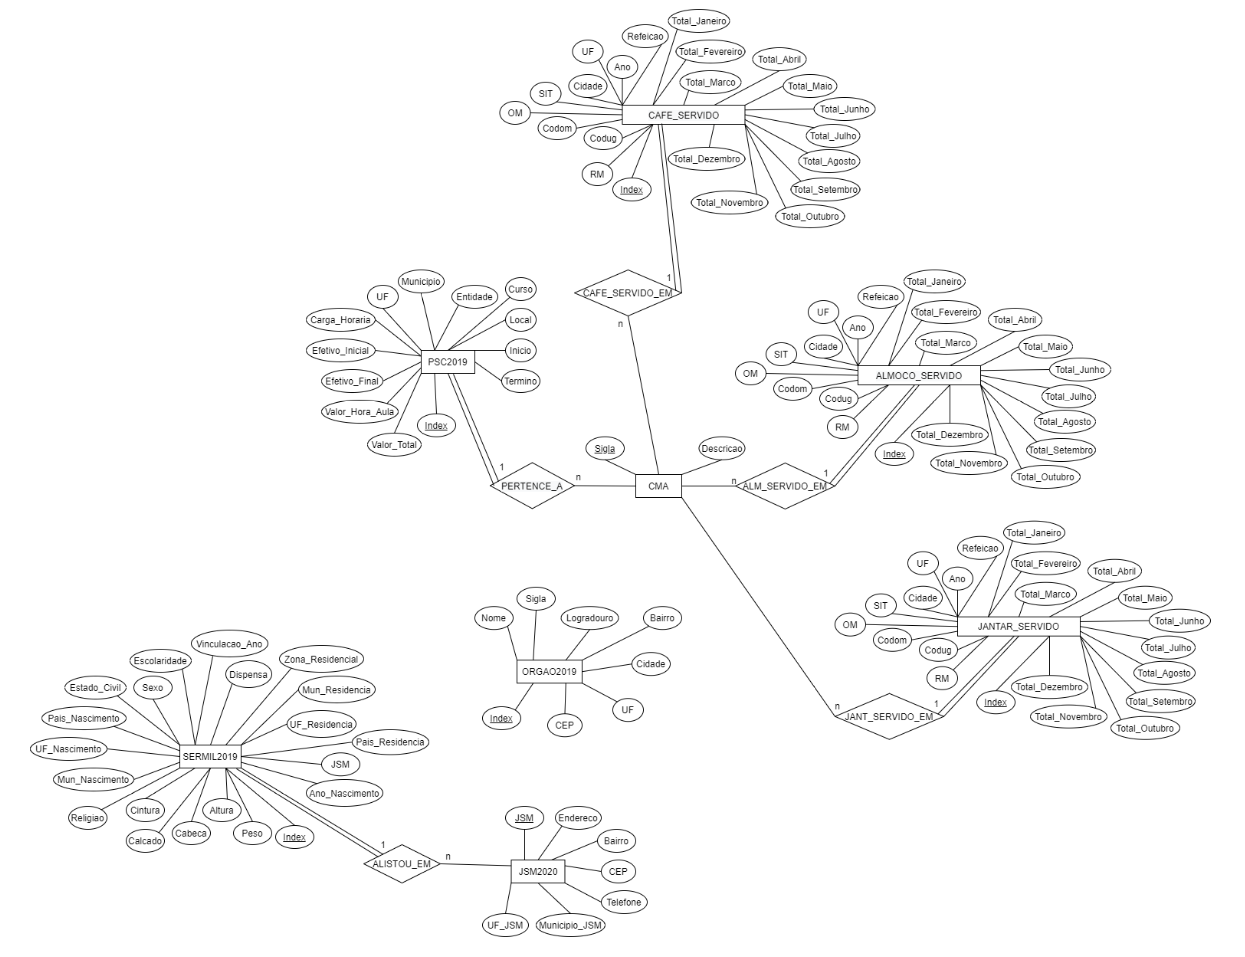

# 5. Diagrama relacional


https://github.com/voidmarcus/eb_files/blob/main/esquema-relacional.jpeg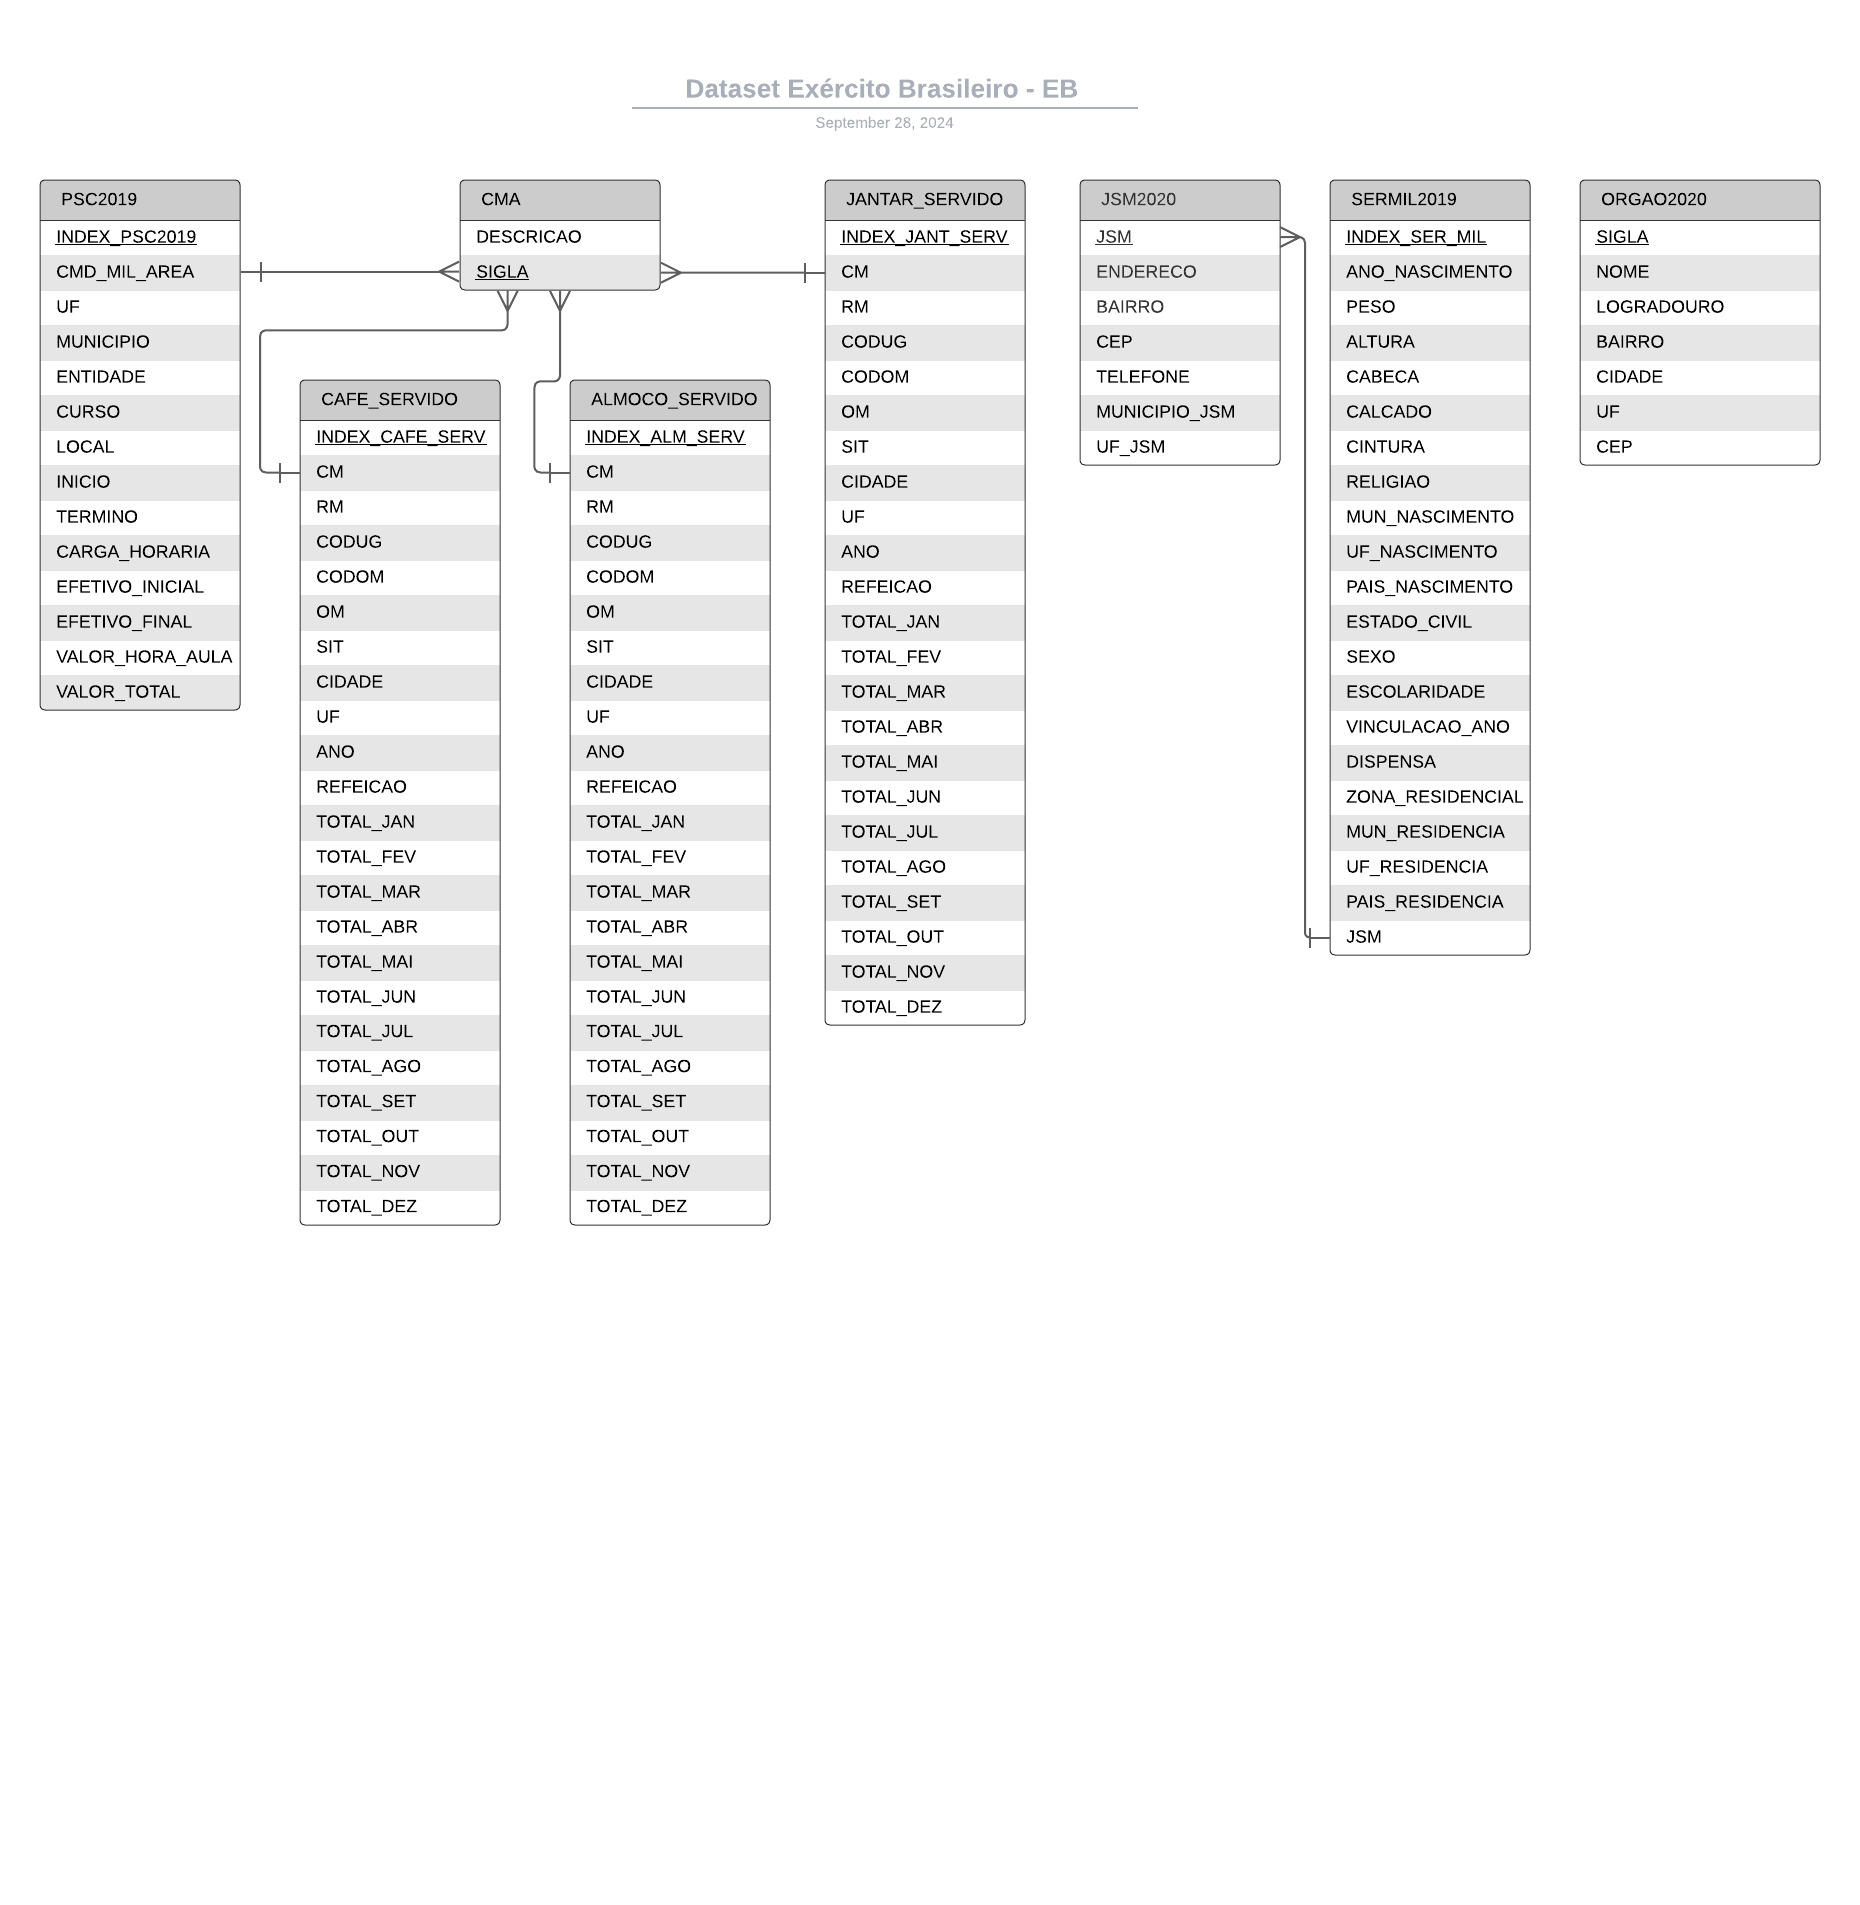

# 6. Consultas

O objetivo desse tópico é exercitar os conhecimentos adquiridos e comparar as diferentes técnicas.

## 6.1 Duas consultas envolvendo seleção e projeção

### 6.1.1 Consulta 1 (duas versões)

1.1 - Quantas pessoas se apresentaram para o alistamento militar no ano de 2019 moram no estado de MG?

In [ ]:
query_1_1 = """
SELECT COUNT()
FROM 
  sermil2019
WHERE
  UF_NASCIMENTO = 'MG'
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_1_1, conn)

100 loops, best of 5: 14.2 ms per loop


In [ ]:
df = pd.read_sql_query(query_1_1, conn)
df

,COUNT()
0,5922


1.2

In [ ]:
query_1_2 = """
SELECT COUNT()
FROM (
	SELECT *
	FROM sermil2019
	WHERE UF_NASCIMENTO = 'MG'
	)
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_1_2, conn)

100 loops, best of 5: 14.2 ms per loop


In [ ]:
df = pd.read_sql_query(query_1_2, conn)
df

,COUNT()
0,5922


**Comparação entre as querys:**

A diferênça entre as duas querys está na forma em que fazemos o COUNT. Enquanto uma query faz o COUNT de maneira direta (dentro do próprio select), a outra utiliza de dois selects, um para a cláusula WHERE e outro somente para o COUNT. Embora a forma de contrução seja diferente, o tempo gasto para a execução tende a ser o mesmo, ambos com demoraram (no melhor dos casos) 14.2 ms para ser executado. 

### 6.1.2 Consulta 2 (duas versões)

2.1 - Quantas pessoas nascidas no ano de 1999 se apresentaram para o alistamento militar no ano de 2019?

In [ ]:
query_2_1 = """
SELECT COUNT()
FROM 
  sermil2019
WHERE
  ANO_NASCIMENTO = 1999
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_2_1, conn)

100 loops, best of 5: 11.2 ms per loop


In [ ]:
df = pd.read_sql_query(query_2_1, conn)
df

,COUNT()
0,4465


2.2

In [ ]:
query_2_2 = """
SELECT COUNT()
FROM (
	SELECT *
	FROM sermil2019
	WHERE ANO_NASCIMENTO = '1999'
	)
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_2_2, conn)

100 loops, best of 5: 14.8 ms per loop


In [ ]:
df = pd.read_sql_query(query_2_2, conn)
df

,COUNT()
0,4465


**Comparação entre as querys:**

A diferênça entre as duas querys é bem simples. Uma está fazendo um WHERE com um dado númerico, enquanto a outra o faz com o dado em formato de string. O resultado, como esperado, é que a query que utiliza um dado númeroco tende a ser mais rápido do que uma string (11 ms VS 14 ms).


## 6.2 Três consultas envolvendo junção de duas relações

### 6.2.1 Consulta 3 (duas versões)

3.1 - Qual o endereço do JSM que mais recebeu pessoas para o alistamento militar no ano de 2019? Imprima endereço e quantidade.

In [ ]:
query_3_1 = """
SELECT ENDERECO
	,MAX(qtd) AS qtd
FROM (
	SELECT A.JSM
		,COUNT(A.JSM) AS qtd
		,B.ENDERECO
	FROM sermil2019 A
	INNER JOIN jsm2020 B ON A.JSM = B.JSM
	GROUP BY A.JSM
	)
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_3_1, conn)

10 loops, best of 5: 166 ms per loop


In [ ]:
# print resultado
df = pd.read_sql_query(query_3_1, conn)
df

,ENDERECO,qtd
0,RUA LUIZ MANOEL Nº 100,1974


3.2

In [ ]:
query_3_2 = """
SELECT B.ENDERECO
	,COUNT(A.JSM) AS qtd
FROM sermil2019 A
INNER JOIN jsm2020 B ON A.JSM = B.JSM
GROUP BY A.JSM
ORDER BY qtd DESC LIMIT 1
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_3_2, conn)

10 loops, best of 5: 163 ms per loop


In [ ]:
df = pd.read_sql_query(query_3_2, conn)
df

,ENDERECO,qtd
0,RUA LUIZ MANOEL Nº 100,1974


**Comparação entre as querys:**

A diferênça entre as duas querys é que uma utiliza a função MAX para selecionar o maior valor do resultado obtido, enquanto a outra ordena os resultados de forma decrescente e o limita a uma unica saída. 

Acho interessante a performance das duas querys que tendem a ser iguais, mas com uma leve vantagem para a segunda. Acredito que essa performance seja pontual e não generica, haja visto que nossos dados são limitados e que algoritmos de ordenação são mais custosos que de comparação. 

### **6.2.2 Consulta 4 (duas versões)**

4.1 - Quantos órgãos  militares existem na UF de que se alistou menos pessoas no ano de 2019?

In [ ]:
query_4_1 = """
SELECT COUNT()
FROM ORGAO2020
WHERE UF IN (
		SELECT UF_JSM
		FROM (
			SELECT UF_JSM
				,COUNT(UF_JSM) AS qtd
			FROM jsm2020 AS J
				,(
					SELECT *
					FROM sermil2019
					) AS S
			WHERE J.JSM = S.JSM
			GROUP BY UF_JSM
			ORDER BY qtd ASC LIMIT 1
			)
		)
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_4_1, conn)

10 loops, best of 5: 132 ms per loop


In [ ]:
df = pd.read_sql_query(query_4_1, conn)
df

,COUNT()
0,6


4.2

In [ ]:
query_4_2 = """
SELECT COUNT(*)
FROM ORGAO2020 A
INNER JOIN (
	SELECT J.UF_JSM
		,COUNT(J.JSM) AS qtd
	FROM jsm2020 J
	INNER JOIN sermil2019 S ON J.JSM = S.JSM
	GROUP BY J.UF_JSM
	ORDER BY qtd ASC LIMIT 1
	) B ON A.UF = B.UF_JSM
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_4_2, conn)

10 loops, best of 5: 144 ms per loop


In [ ]:
df = pd.read_sql_query(query_4_2, conn)
df

,COUNT(*)
0,6


**Comparação entre as querys:**

Aqui fiz um experimento bem interessante. A primeira query foi feita somente com SELECT's e WHERE's, enquanto a segunda utilizou JOIN para fazer boa parte do trabalho. A utilização do JOIN deixa o código mais entendível em um primeiro momento, mas a comparação de performance é nítida. A query feita somente com SELECT's foi relativamente mais eficaz com 12ms de diferença. 

### 6.2.3 Consulta 5 (duas versões)


5.1 - Quais Comandos Militares de Área (descrição) atuaram no programa PSC no ano de 2019?

In [ ]:
query_5_1 = """
SELECT DESCRICAO
FROM CMA
WHERE SIGLA IN (
		SELECT CMD_MIL_AREA
		FROM PSC2019
		WHERE INICIO BETWEEN '01/01/2019'
				AND '31/12/2019'
		)
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_5_1, conn)

1000 loops, best of 5: 660 µs per loop


In [ ]:
df = pd.read_sql_query(query_5_1, conn)
df

,DESCRICAO
0,Comando Militar da Amazonia
1,Comando Militar do Leste
2,Comando Militar do Norte
3,Comando Militar do Nordeste
4,Comando Militar do Oeste
5,Comando Militar do Planalto
6,Comando Militar do Sul


5.2

In [ ]:
query_5_2 = """
SELECT DISTINCT (DESCRICAO)
FROM CMA A
INNER JOIN PSC2019 B ON A.SIGLA = B.CMD_MIL_AREA
WHERE B.INICIO BETWEEN '01/01/2019'
		AND '31/12/2019'
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_5_2, conn)

The slowest run took 9.70 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 700 µs per loop


In [ ]:
df = pd.read_sql_query(query_5_2, conn)
df

,DESCRICAO
0,Comando Militar da Amazonia
1,Comando Militar do Nordeste
2,Comando Militar do Norte
3,Comando Militar do Planalto
4,Comando Militar do Leste
5,Comando Militar do Oeste
6,Comando Militar do Sul


**Comparação entre as querys:**

Repeti o experimento da questão anterior e novamente obtive uma performance um pouco melhor da query que foi feita somente com SELECT's e WHERE's, enquanto query que utilizou JOIN para fazer boa parte do trabalho demorou 40µs a mais para executar.

## 6.3 Três consultas envolvendo junção de três ou mais relações

### 6.3.1 Consulta 6 (duas versões)

6.1 - O Comando Militar de Área que mais serviu alimentação de café da manhã, participou de quais PSC’s? 

PS: Comparando joins com selects. Veja análise logo após a segunda query

In [ ]:
query_6_1 = """
SELECT P.CURSO AS CURSO
	,C.DESCRICAO AS DESCRICAO
FROM PSC2019 AS P
INNER JOIN CMA AS C
WHERE CMD_MIL_AREA IN (
		SELECT CMA
		FROM (
			SELECT CMA
				,SUM(TOTAL) AS TOTAL
			FROM (
				SELECT DISTINCT CM AS CMA
					,TOTAL_JAN + TOTAL_FEV + TOTAL_MAR + TOTAL_ABR + TOTAL_MAI + TOTAL_JUN + TOTAL_JUL + TOTAL_AGO + TOTAL_SET + TOTAL_OUT + TOTAL_NOV + TOTAL_DEZ AS TOTAL
				FROM cafe_servido_EB_2017
				WHERE TOTAL IS NOT NULL
					AND TOTAL != 0
				)
			GROUP BY CMA
			ORDER BY TOTAL DESC LIMIT 1
			)
		)
	AND C.SIGLA = P.CMD_MIL_AREA
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_6_1, conn)

The slowest run took 4.94 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.96 ms per loop


In [ ]:
df = pd.read_sql_query(query_6_1, conn)
df

,CURSO,DESCRICAO
0,Auxiliar de Marcenaria,Comando Militar do Sul
1,Auxiliar de Panificação,Comando Militar do Sul
2,Auxiliar de Mecânica Básica,Comando Militar do Sul
3,Aproveitamento de Alimentos,Comando Militar do Sul
4,Injeção eletrônica de motocicletas,Comando Militar do Sul
...,...,...
127,Excel Básico,Comando Militar do Sul
128,Condutor de coletivo de passageiros,Comando Militar do Sul
129,Condutor de veículo de emergência,Comando Militar do Sul
130,Soldador MIG/MAG,Comando Militar do Sul


6.2

In [ ]:
query_6_2 = """
SELECT C.CURSO
	,B.DESCRICAO
FROM (
	SELECT CM
		,MAX(TOTAL)
	FROM (
		SELECT CM
			,SUM(TOTAL) AS TOTAL
		FROM (
			SELECT DISTINCT CM
				,TOTAL_JAN + TOTAL_FEV + TOTAL_MAR + TOTAL_ABR + TOTAL_MAI + TOTAL_JUN + TOTAL_JUL + TOTAL_AGO + TOTAL_SET + TOTAL_OUT + TOTAL_NOV + TOTAL_DEZ AS TOTAL
			FROM cafe_servido_EB_2017
			WHERE TOTAL IS NOT NULL
			)
		GROUP BY CM
		ORDER BY TOTAL DESC
		)
	) A
INNER JOIN CMA B ON A.CM = B.SIGLA
INNER JOIN PSC2019 C ON B.SIGLA = C.CMD_MIL_AREA
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_6_2, conn)

1000 loops, best of 5: 1.71 ms per loop


In [ ]:
df = pd.read_sql_query(query_6_2, conn)
df

,CURSO,DESCRICAO
0,Auxiliar de Marcenaria,Comando Militar do Sul
1,Auxiliar de Panificação,Comando Militar do Sul
2,Auxiliar de Mecânica Básica,Comando Militar do Sul
3,Aproveitamento de Alimentos,Comando Militar do Sul
4,Injeção eletrônica de motocicletas,Comando Militar do Sul
...,...,...
127,Excel Básico,Comando Militar do Sul
128,Condutor de coletivo de passageiros,Comando Militar do Sul
129,Condutor de veículo de emergência,Comando Militar do Sul
130,Soldador MIG/MAG,Comando Militar do Sul


**Comparação entre as querys:**

Mais uma vez, repeti o experimento da questão 6.2, em comparação a performance de uma query que foi feita somente com SELECT's e WHERE's, com uma query que utilizou JOIN para fazer boa parte do trabalho. E novamente a primeira query ganhou, com 6ms de diferença.

### 6.3.2 Consulta 7 (duas versões)

7 - O Comando Militar de Área, que mais participou das PSC’s, serviu quantos cafés da manhã no ano?

In [ ]:
query_7_1 = """
SELECT
  CM AS CMA, C.DESCRICAO AS DESCRICAO, SUM(TOTAL) AS TOTAL
FROM(
SELECT
  CM, TOTAL_JAN + TOTAL_FEV + TOTAL_MAR + TOTAL_ABR + TOTAL_MAI + TOTAL_JUN + TOTAL_JUL + TOTAL_AGO + TOTAL_SET + TOTAL_OUT + TOTAL_NOV + TOTAL_DEZ AS TOTAL
FROM 
  cafe_servido_EB_2017
WHERE
  TOTAL IS NOT NULL AND CM IN(SELECT
                                CMD_MIL_AREA
                              FROM( SELECT 
                                      CMD_MIL_AREA, COUNT(CMD_MIL_AREA) as qtd
                                    FROM
                                      PSC2019
                                    GROUP BY CMD_MIL_AREA
                                    ORDER BY qtd DESC
                                    LIMIT 1))) 
INNER JOIN CMA AS C 
WHERE
 C.SIGLA = CMA
"""


In [ ]:
%%timeit
df = pd.read_sql_query(query_7_1, conn)

1000 loops, best of 5: 1.42 ms per loop


In [ ]:
df = pd.read_sql_query(query_7_1, conn)
df

,CMA,DESCRICAO,TOTAL
0,CMS,Comando Militar do Sul,5017465


7.2

In [ ]:
query_7_2 = """
SELECT A.CMD_MIL_AREA AS CMA
	,B.DESCRICAO
	,C.TOTAL
FROM (
	SELECT CMD_MIL_AREA
		,COUNT(CMD_MIL_AREA) AS TOTAL
	FROM psc2019 A
	GROUP BY A.CMD_MIL_AREA
	ORDER BY TOTAL DESC LIMIT 1
	) A
INNER JOIN CMA B ON A.CMD_MIL_AREA = B.SIGLA
INNER JOIN (
	SELECT CM, SUM(TOTAL) AS TOTAL
  FROM(
	SELECT DISTINCT CM
		,TOTAL_JAN + TOTAL_FEV + TOTAL_MAR + TOTAL_ABR + TOTAL_MAI + TOTAL_JUN + TOTAL_JUL + TOTAL_AGO + TOTAL_SET + TOTAL_OUT + TOTAL_NOV + TOTAL_DEZ AS TOTAL
	FROM cafe_servido_EB_2017
	WHERE TOTAL IS NOT NULL)
  GROUP BY CM
  ORDER BY TOTAL DESC
	) C ON C.CM = B.SIGLA
"""


In [ ]:
%%timeit
df = pd.read_sql_query(query_7_2, conn)

1000 loops, best of 5: 1.79 ms per loop


In [ ]:
df = pd.read_sql_query(query_7_2, conn)
df

,CMA,DESCRICAO,TOTAL
0,CMS,Comando Militar do Sul,5017465


**Comparação entre as querys:**

Para finalizar esse estudo empírico sobre performance do join vs select, fiz essa ultima comparação, que mostrou mais uma vez que o uso do join é mesmo um fator determinante na performance de uma query.

### 6.3.3 Consulta 8

8.1 - Quais os Comandos Militares de Área, que estão na UF de Minas Gerais e participaram do PSC, serviram mais de 10000 mil almoços no mês de janeiro?

In [ ]:
query_8_1 = """
SELECT DISTINCT (P.CMD_MIL_AREA)
	,c.DESCRICAO
	,a.TOTAL_JAN
FROM psc2019 p
INNER JOIN cma c ON p.CMD_MIL_AREA = c.SIGLA
INNER JOIN almoco_servido_EB_2017 a ON p.CMD_MIL_AREA = a.CM
WHERE p.UF = 'MG'
	AND CAST(a.TOTAL_JAN AS INT) > '10000'
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_8_1, conn)

1000 loops, best of 5: 1.55 ms per loop


In [ ]:
df = pd.read_sql_query(query_8_1, conn)
df

,CMD_MIL_AREA,DESCRICAO,TOTAL_JAN
0,CML,Comando Militar do Leste,14196


8.2

In [ ]:
query_8_2 = """
SELECT DISTINCT (P.CMD_MIL_AREA)
	,c.DESCRICAO
	,a.TOTAL_JAN
FROM psc2019 p
INNER JOIN cma c ON p.CMD_MIL_AREA = c.SIGLA
INNER JOIN (
	SELECT *
	FROM almoco_servido_EB_2017 a
	WHERE CAST(a.TOTAL_JAN AS INT) > '10000'
	) a ON p.CMD_MIL_AREA = a.CM
WHERE p.UF = 'MG'
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_8_2, conn)

100 loops, best of 5: 2.45 ms per loop


In [ ]:
df = pd.read_sql_query(query_8_2, conn)
df

,CMD_MIL_AREA,DESCRICAO,TOTAL_JAN
0,CML,Comando Militar do Leste,14196


**Comparação entre as querys**:

Nesta comparação, observei o impacto do uso de uma subquery utilizando um WHERE e logo depois INNER JOIN e outro WHERE vs um WHERE unico depois do JOIN. A performace do segundo caso (query 1) é bem mais eficaz, chegando próximo da metade do primeiro caso (query 2).

## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Consulta 9 (duas versões)

9.1 - Mostre, por UF’s, quais os CMA’s quem mais serviram jantares e participaram dos PSC’s em 2019.

In [ ]:
query_9_1 = """
SELECT G.UF AS UF
	,CM
	,SUM(TOTAL) AS TOTAL
FROM (
	SELECT UF
		,CM
		,TOTAL_JAN + TOTAL_FEV + TOTAL_MAR + TOTAL_ABR + TOTAL_MAI + TOTAL_JUN + TOTAL_JUL + TOTAL_AGO + TOTAL_SET + TOTAL_OUT + TOTAL_NOV + TOTAL_DEZ AS TOTAL
	FROM jantar_servido_EB_2017
	WHERE TOTAL IS NOT NULL
	) G
INNER JOIN PSC2019 P ON G.CM = P.CMD_MIL_AREA
GROUP BY G.UF
	,CM
ORDER BY TOTAL DESC LIMIT 5

"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_9_1, conn)

10 loops, best of 5: 40.2 ms per loop


In [ ]:
df = pd.read_sql_query(query_9_1, conn)
df

,UF,CM,TOTAL
0,RS,CMS,193420920
1,PR,CMS,125620968
2,SC,CMS,66948816
3,MS,CMO,58346141
4,DF,CMP,56786655


9.2

In [ ]:
query_9_2 = """
SELECT B.UF
	,A.CMD_MIL_AREA
	,B.Total
FROM (
	SELECT CMD_MIL_AREA
		,UF
	FROM psc2019
	GROUP BY CMD_MIL_AREA
	) A
INNER JOIN (
	SELECT CM
		,UF
		,TOTAL_JAN + TOTAL_FEV + TOTAL_MAR + TOTAL_ABR + TOTAL_MAI + TOTAL_JUN + TOTAL_JUL + TOTAL_AGO + TOTAL_SET + TOTAL_OUT + TOTAL_NOV + TOTAL_DEZ AS TOTAL
	FROM jantar_servido_EB_2017
	WHERE TOTAL IS NOT NULL
	GROUP BY UF
		,CM
	) B ON A.CMD_MIL_AREA = B.CM
ORDER BY B.TOTAL DESC
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_9_2, conn)

1000 loops, best of 5: 1.8 ms per loop


In [ ]:
df = pd.read_sql_query(query_9_1, conn)
df

,UF,CM,TOTAL
0,RS,CMS,193420920
1,PR,CMS,125620968
2,SC,CMS,66948816
3,MS,CMO,58346141
4,DF,CMP,56786655


**Comparação entre as querys:**

Sei que o inner join pode gerar um produto cartesiano e por isso quiz explorar esse ponto. Em uma das querys fiz todas as operações e ao final limitamos o resultado à 5 linhas. Em outra, fiz essa limitação o mais cedo possível e só depois apliquei um dos inner join. O resultado foi como esperado, o primeiro caso gastou 40ms para rodar, enquanto que o segundo gastou somente 1.8 ms.

### 6.4.2 Consulta 10 (duas versões)

10.1 - Mostre, por entidade, quais os CMA’S que mais investiram em PSC’s.

In [ ]:
query_10_1 = """
SELECT
  A.DESCRICAO, B.CM, B.ENTIDADE, B.VALOR_TOTAL
FROM(
SELECT 
  ENTIDADE, CMD_MIL_AREA AS CM, SUM(CAST(REPLACE(REPLACE(VALOR_TOTAL, 'R$', ''), '.', '') AS INT)) AS VALOR_TOTAL
FROM
 PSC2019 
GROUP BY ENTIDADE, CM
ORDER BY VALOR_TOTAL DESC) B INNER JOIN CMA A
WHERE B.CM = A.SIGLA
LIMIT 5

"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_10_1, conn)

1000 loops, best of 5: 1.53 ms per loop


In [ ]:
df = pd.read_sql_query(query_10_1, conn)
df

,DESCRICAO,CM,ENTIDADE,VALOR_TOTAL
0,Comando Militar do Planalto,CMP,SENAI,459418
1,Comando Militar da Amazonia,CMA,CENTRO DE EDUCAÇÃO TECNOLÓGICA DO AMAZONAS,304640
2,Comando Militar do Sul,CMS,Centro de Formação de Condutores Verde Oliva,184150
3,Comando Militar do Oeste,CMO,SENAI -MT,160498
4,Comando Militar do Nordeste,CMNE,SENAI,137773


10.2

In [ ]:
query_10_2 = """
SELECT A.DESCRICAO
	,B.CMD_MIL_AREA
	,B.ENTIDADE
	,B.VALOR_TOTAL
FROM cma A
INNER JOIN (
	SELECT CMD_MIL_AREA
		,ENTIDADE
		,SUM(CAST(REPLACE(REPLACE(VALOR_TOTAL, 'R$', ''), '.', '') AS INT)) AS VALOR_TOTAL
	FROM PSC2019
	GROUP BY CMD_MIL_AREA
		,ENTIDADE
	ORDER BY VALOR_TOTAL DESC LIMIT 5
	) B ON A.SIGLA = B.CMD_MIL_AREA
"""

In [ ]:
%%timeit
df = pd.read_sql_query(query_10_2, conn)

1000 loops, best of 5: 1.57 ms per loop


In [ ]:
df = pd.read_sql_query(query_10_2, conn)
df

,DESCRICAO,CMD_MIL_AREA,ENTIDADE,VALOR_TOTAL
0,Comando Militar do Planalto,CMP,SENAI,459418
1,Comando Militar da Amazonia,CMA,CENTRO DE EDUCAÇÃO TECNOLÓGICA DO AMAZONAS,304640
2,Comando Militar do Sul,CMS,Centro de Formação de Condutores Verde Oliva,184150
3,Comando Militar do Oeste,CMO,SENAI -MT,160498
4,Comando Militar do Nordeste,CMNE,SENAI,137773


**Comparação entre as querys:** 

Aqui nós fiz novamente o experimento anterior (6.4), mas não obtive resultados similares. Neste caso, houve um certo empate com cerca de 1.5 ms de tempo de execução para ambos. Acredito que seja por conta do ORDER BY, que aparece para as duas querys em momentos similares, deixando-as com desempenho parecido.